Populating the interactive namespace from numpy and matplotlib
Coefficients:  [[ 0.13544226  0.15674916 -0.1513797  -0.06920642 -0.95795523  0.11060633
  -0.39159699  0.31239638  0.44601438 -0.1712504  -0.13603438 -0.58529426
   0.27038214  0.02099664  0.77465077]]
bias:  [0.51257044]
Mean squared error: 0.02
R²: 0.77
(12, 1) : (12, 1)


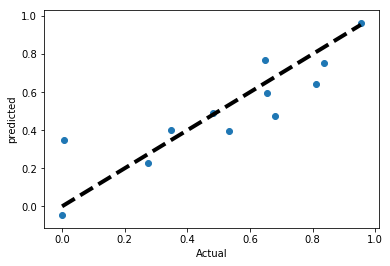

      Actual  Predicted
0   0.274191   0.229832
1   0.007333   0.350639
2   0.654711   0.598017
3   0.954248   0.964264
4   0.680536   0.473106
5   0.346405   0.402512
6   0.532122   0.394762
7   0.000000  -0.047156
8   0.812052   0.643759
9   0.835645   0.753080
10  0.481907   0.489665
11  0.649609   0.770129


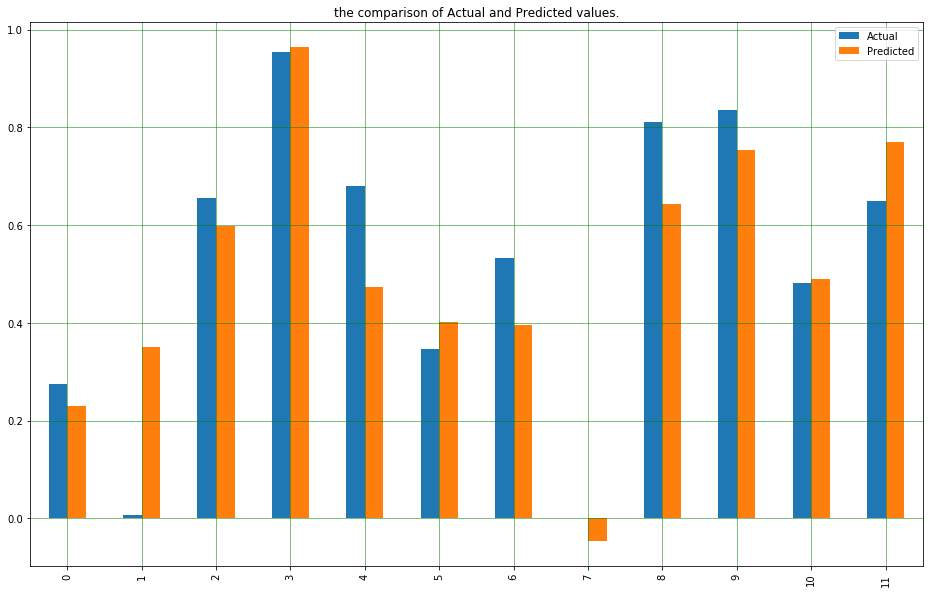

QSAR Equation :  y = AATS5p * 0.14 + AATSC1v * 0.16 + SpMax4_Bhi * -0.15 + SpMin4_Bhi * -0.07 + SHCHnX * -0.96 + SHCsats * 0.11 + SsssCH * -0.39 + minsssCH * 0.31 + maxHCHnX * 0.45 + maxHCsats * -0.17 + ETA_Beta_ns * -0.14 + nHBAcc_Lipinski * -0.59 + MIC5 * 0.27 + piPC6 * 0.02 + TopoPSA * 0.77 + 0.5125704426159348


In [62]:
'''

2019. 09. 09.

by Yumi Kim CBBL at GNU
Linear Regression and Building the QSAR Model
And K-Fold Validation

'''
%matplotlib inline
%pylab inline

# Import Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import KFold

raw_dataset = pd.read_csv('train_x_univariate_feature_selection_f_regression_15.csv')

# Remove "SMILE" column
if 'smile' in raw_dataset.columns:
    raw_dataset = raw_dataset.drop("smile", axis = 1) 

col_list = raw_dataset.columns

# Set for dataSet
raw_array = raw_dataset.values
x_data = raw_array[:,0:-1]
y_data = raw_array[:,[-1]]

# Data Scaling
scaler = MinMaxScaler(feature_range=(0, 1)) 
x_data = scaler.fit_transform(x_data)
y_data = scaler.fit_transform(y_data)

def get_linear_regresion(x_data, y_data):
    
    X_train, X_eval,y_train,y_eval=train_test_split(x_data,y_data,test_size=0.2,random_state=101)
    
    reg = LinearRegression()
    reg.fit(X_train, y_train)

    y_predicted = reg.predict(X_eval)

    bias = reg.intercept_
    weights = reg.coef_
    mse = mean_squared_error(y_eval, y_predicted)
    r2_value = r2_score(y_eval, y_predicted)
    
    print("Coefficients: ", reg.coef_)
    print("bias: ", bias)
    print("Mean squared error: %.2f" %mse )
    print('R²: %.2f' %r2_value )
    
    if(r2_value > 0.7):
        print(y_eval.shape,":",y_predicted.shape)
        fig, ax = plt.subplots()
        ax.scatter(y_eval, y_predicted)
        ax.plot([y_eval.min(), y_eval.max()], [y_eval.min(), y_eval.max()], 'k--', lw=4)
        ax.set_xlabel('Actual')
        ax.set_ylabel('predicted')
        plt.show()

        df = pd.DataFrame({'Actual': y_eval.flatten(), 'Predicted': y_predicted.flatten()})
        print(df)
        df.plot(kind='bar',figsize=(16,10))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.title("the comparison of Actual and Predicted values.")
        plt.show()
    
    return bias, weights, mse, r2_value

## Get predictions from each split of cross-validation for diagnostic purposes.
## The data is split according to the cv parameter. 
## Each sample belongs to exactly one test set, 
## and its prediction is computed with an estimator fitted on the corresponding training set.
def get_cross_val_predict(x_data, y_data):
    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    lr = linear_model.LinearRegression()
    predicted = cross_val_predict(lr, x_data, y_data, cv=3)
    
    fig, ax = plt.subplots()
    ax.scatter(y_data, predicted, edgecolors=(0, 0, 0))
    ax.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.title("Cross Validated Prediction Plot")
    plt.show()

# Evaluate metric(s) by cross-validation and also record fit/score times.
def get_cross_validate(x_data, y_data):
    
    lr = linear_model.LinearRegression()
    cv_results = cross_validate(lr, x_data, y_data, cv=3)
    sorted(cv_results.keys())                         
    return cv_results['test_score']    
    
def get_kfold_validation(x_data, y_data):
    
    kfold = KFold(n_splits=5) 
    reg = LinearRegression()
    for n in [3, 5]:
        kfold = KFold(n_splits=n, shuffle=True, random_state=0)
        scores = cross_val_score(reg, x_data, y_data, cv=kfold)
        print('n_splits={}, cross validation score: {}'.format(n, scores))
        
def get_qsar_equation(bias, weights, cols_num):
    equation = "y = "
    
    if(cols_num == 1):
        equation += col_list[c_vals[0]]+" * "+str("%0.2f" %weights[0]) + " + " + str(bias[0])
         
    else:
        weights = np.squeeze(weights)
        #print("Debug QSAR Equation : ", bias, weights, cols_num)
        
        for i in range(cols_num):
            equation += col_list[i]+ " * "+str("%0.2f" %weights[i]) + " + "
        equation += str(bias[0]) 
    
    return equation
# Execute Linear Regression and Get QSAR Equation
bias, weights, mse, r2_value = get_linear_regresion(x_data, y_data)
qsar_equation = get_qsar_equation(bias, weights, x_data.shape[1])
print("QSAR Equation : ",qsar_equation)

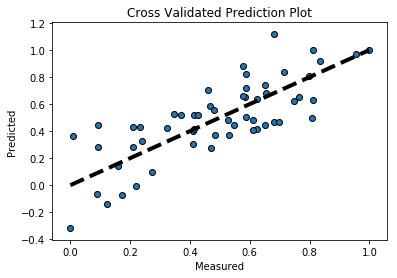

In [38]:
get_cross_val_predict(x_data, y_data)

In [39]:
print(get_cross_validate(x_data, y_data))

[0.23850697 0.44215347 0.51605741]


In [63]:
get_kfold_validation(x_data, y_data)

n_splits=3, cross validation score: [ 0.59034016  0.2367687  -0.1408015 ]
n_splits=5, cross validation score: [0.54396031 0.81899263 0.31112684 0.11644723 0.38616362]
